# Model comparison

To demonstrate the use of model comparison criteria in PyMC 3, we implement the **8 schools** example from Section 5.5 of Gelman et al (2003), which attempts to infer the effects of coaching on SAT scores of students from 8 schools. Below, we fit a **pooled model**, which assumes a single fixed effect across all schools, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
from pymc3 import (Normal, HalfCauchy, sample, Model, waic, dic, loo, forestplot, 
                   traceplot, NUTS, find_MAP, Deterministic, HalfCauchy)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

The data include the observed treatment effects and associated standard deviations in the 8 schools.

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

### Pooled model

In [3]:
with Model() as pooled:
    
    mu = Normal('mu', 0, sd=1e6)
    
    obs = Normal('obs', mu, sd=sigma, observed=y)

In [4]:
with pooled:
    trace_p = sample(2000)

Assigned NUTS to mu
 [-----------------100%-----------------] 2000 of 2000 complete in 0.5 sec

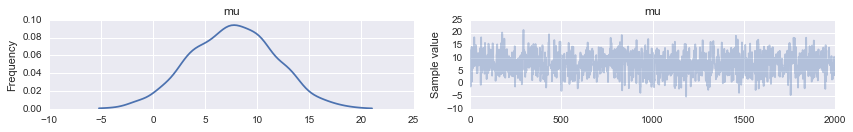

In [5]:
traceplot(trace_p, varnames=['mu']);

### Hierarchical model

In [6]:
with Model() as hierarchical:
    
    eta = Normal('eta', 0, 1, shape=J)
    mu = Normal('mu', 0, sd=1e6)
    tau = HalfCauchy('tau', 5)
    
    theta = Deterministic('theta', mu + tau*eta)
    
    obs = Normal('obs', theta, sd=sigma, observed=y)

Applied log-transform to tau and added transformed tau_log to model.


In [7]:
with hierarchical:
    trace_h = sample(2000)

Assigned NUTS to eta
Assigned NUTS to mu
Assigned NUTS to tau_log
 [-----------------100%-----------------] 2000 of 2000 complete in 2.8 sec

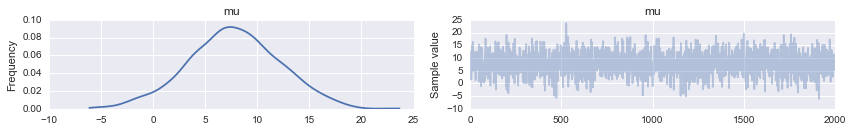

In [8]:
traceplot(trace_h, varnames=['mu']);

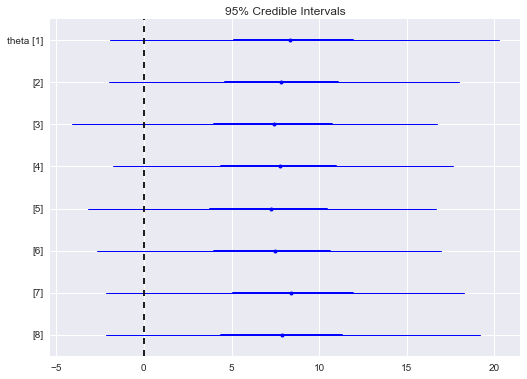

In [9]:
forestplot(trace_h, varnames=['theta']);

### Deviance Information Criterion (DIC)

DIC (Spiegelhalter et al. 2002) is an information theoretic criterion for estimating predictive accuracy that is analogous to Akaike's Information Criterion (AIC). It is a more Bayesian approach that allows for the modeling of random effects, replacing the maximum likelihood estimate with the posterior mean and using the effective number of parameters to correct for bias.

In [10]:
with pooled:
    pooled_dic = dic(trace_p)
    
pooled_dic

90.820836187192754

In [11]:
with hierarchical:
    hierarchical_dic = dic(trace_h)
    
hierarchical_dic

/Users/fonnescj/Repositories/pymc3/pymc3/stats.py:92: UserWarning: 
            DIC estimates are biased for models that include transformed random variables.
            See https://github.com/pymc-devs/pymc3/issues/789.
            The following random variables are the result of transformations:
            tau_log
        
  """.format(', '.join(rv.name for rv in transformed_rvs)))


129.09933793995285

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

In [12]:
with pooled:
    pooled_waic = waic(trace_p)
    
pooled_waic

61.079357411617409

In [13]:
with hierarchical:
    hierarchical_waic = waic(trace_h)
    
hierarchical_waic

/Users/fonnescj/Repositories/pymc3/pymc3/stats.py:121: UserWarning: 
            WAIC estimates are biased for models that include transformed random variables.
            See https://github.com/pymc-devs/pymc3/issues/789.
            The following random variables are the result of transformations:
            tau_log
        
  """.format(', '.join(rv.name for rv in transformed_rvs)))


61.54556775762817

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is a estimate of out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of pointwise out-of-sample prediction accuracy.

In [14]:
with pooled:
    pooled_loo = loo(trace_p)
    
pooled_loo

/Users/fonnescj/Repositories/pymc3/pymc3/stats.py:158: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate 
        is very large.
  is very large.""")


-29.885359174300234

In [15]:
with hierarchical:
    hierarchical_loo = loo(trace_h)
    
hierarchical_loo

/Users/fonnescj/Repositories/pymc3/pymc3/stats.py:158: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate 
        is very large.
  is very large.""")


-29.781009435144412

### Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, with the pooling model actually providing the best average predictive performance.

## Reference

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997â€“1016.](http://doi.org/10.1007/s11222-013-9416-2)